In [88]:
# install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pip install folium

!{sys.executable} -m pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
# importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import haversine as hs
import folium
import warnings
from functools import reduce

# Settings
pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


#setting backend for matplotlib
%matplotlib inline

#setting plot style
plt.style.use('seaborn-white')

In [90]:
# loading the dataset
fraud_train = pd.read_csv('/content/drive/MyDrive/TCC- credit card fraud/fraudTrain.csv')
fraud_test = pd.read_csv('/content/drive/MyDrive/TCC- credit card fraud/fraudTest.csv')

#concatenating the two datasets
df = pd.concat([fraud_train, fraud_test]).reset_index()

df.drop(df.columns[:2], axis=1, inplace=True)
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


# PRÉ-PROCESSAMENTO

In [154]:
# checking features info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 31 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   index                    int64         
 1   trans_date_trans_time    object        
 2   cc_num                   object        
 3   merchant                 object        
 4   category                 object        
 5   amt                      float64       
 6   first                    object        
 7   last                     object        
 8   gender                   object        
 9   street                   object        
 10  city                     object        
 11  state                    object        
 12  zip                      int64         
 13  lat                      float64       
 14  long                     float64       
 15  city_pop                 int64         
 16  job                      object        
 17  dob                      da

In [92]:
# converting trans_date_trans_time into datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
print(df.dtypes['trans_date_trans_time'])


datetime64[ns]


In [93]:
# deriving additonal columns from 'trans_date_trans_time'
#deriving hour
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
#deriving 'day of the week'
df['trans_week_day'] = df['trans_date_trans_time'].dt.day_name()
#deriving 'year_month'
df['trans_month'] = df['trans_date_trans_time'].dt.month


In [94]:
# finding age
#converting 'dob' column to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - 
                      df['dob'])/np.timedelta64(1, 'Y'))

In [95]:
# concatenating lat and long to create a consolidated location as accepted by haversine function
df['coor_customer'] = list(zip(df.lat, df.long))
df['coor_merchant'] = list(zip(df.merch_lat, df.merch_long))


In [96]:
# defining a  function to calculate distance between two locations 
def distance_from(row): 
    dist=hs.haversine(row['coor_customer'], row['coor_merchant'])
    return round(dist,2)

In [97]:
# calculating distance between customer and merchant
df['dist_cus_merch'] = df.apply(lambda row: distance_from(row), axis=1)


In [98]:
# index as datetime
df_dt = df.set_index('trans_date_trans_time')

In [99]:
# creating var - qty_purc_unti_now_store
df['qty_purc_unti_now_store'] = df.sort_values(['trans_date_trans_time'], ascending=[True])\
             .groupby(['cc_num', 'merchant']).cumcount() + 1

# cheking Variable
#df[(df.cc_num == 630423337322) & (df.merchant.isin(['fraud_Heller, Gutmann and Zieme']))]

In [100]:
# creating var - qty_purc_last_hour_merc
df_merch = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num', 'merchant']).rolling('1H')['amt'].count())\
                            .rename(columns={'amt': 'qty_purc_last_hour_merc'}).astype(int)


In [101]:
# creating var - qty_purc_last_hour
df_1h = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num']).rolling('1H')['amt'].count())\
                            .rename(columns={'amt': 'qty_purc_last_hour'}).astype(int)

In [102]:
# creating var - mean_spet_last_day
df_day = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num']).rolling('1D')['amt'].mean())\
                            .rename(columns={'amt': 'mean_spet_last_day'}).astype(float)

In [103]:
# creating var - mean_spet_last_week
df_week = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num']).rolling('7D')['amt'].mean())\
                            .rename(columns={'amt': 'mean_spet_last_week'}).astype(float)

In [104]:
# creating var - mean_spet_last_mont
df_month = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num']).rolling('30D')['amt'].mean())\
                            .rename(columns={'amt': 'mean_spet_last_mont'}).astype(float)

In [105]:
# creating var - sum_spet_last_mont
df_total = pd.DataFrame(df_dt.sort_index(ascending=True)\
                            .groupby(['cc_num']).rolling('30D')['amt'].sum())\
                            .rename(columns={'amt': 'sum_spet_last_mont'}).astype(float)

In [106]:
# creating a list of dataset
datasets=[df, df_merch, df_1h, df_day, df_week, df_month, df_total]

In [107]:
# reseting index, convert to str to merge dataframes
for dataframe in datasets:
    dataframe.reset_index(inplace=True)
    dataframe['trans_date_trans_time'] = dataframe['trans_date_trans_time'].astype(str)
    dataframe['cc_num'] = dataframe['cc_num'].astype(str)

In [108]:
# merging datasets
intermediate = df.merge(df_merch, how='left', on=['trans_date_trans_time', 'cc_num', 'merchant'])

In [109]:
# removing unnecessary datasets
datasets.remove(df)
datasets.remove(df_merch)

In [110]:
# creating a new list of datasets
dataframes = [intermediate, *datasets]

In [111]:
# merging final datasets
df_final = reduce(lambda  left, right:\
                  pd.merge(left, right, on=['trans_date_trans_time', 'cc_num'], how='inner'), dataframes)

In [112]:
# number of unique values in the dataset
df_final.nunique()

index                      1852394
trans_date_trans_time      1819551
cc_num                         999
merchant                       693
category                        14
amt                          60616
first                          355
last                           486
gender                           2
street                         999
city                           906
state                           51
zip                            985
lat                            983
long                           983
city_pop                       891
job                            497
dob                            984
trans_num                  1852394
unix_time                  1819583
merch_lat                  1754157
merch_long                 1809753
is_fraud                         2
trans_hour                      24
trans_week_day                   7
trans_month                     12
age                             83
coor_customer                  985
coor_merchant       

In [113]:
# dropping variables
df_final.drop(['index',
               'first', 'last', 'dob', 'job', 
               'cc_num', 'merchant', 'trans_num',
               'street', 'zip',
               'lat','long','merch_lat','merch_long'], axis=1, inplace=True)

In [114]:
# saving dataset final version
df_final.to_csv('./df_final.csv', index=False)

# Análise exploratoria

In [115]:
# determing the shape of the dataset
df_final.shape

(1855122, 23)

In [117]:
# describing the dataset
df_final.describe()

,amt,city_pop,unix_time,is_fraud,trans_hour,trans_month,age,dist_cus_merch,qty_purc_unti_now_store,qty_purc_last_hour_merc,qty_purc_last_hour,mean_spet_last_day,mean_spet_last_week,mean_spet_last_mont,sum_spet_last_mont
count,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06,1.855122e+06
mean,7.004870e+01,8.861560e+04,1.358686e+09,5.202353e-03,1.280550e+01,7.153815e+00,4.626080e+01,7.611543e+01,3.150157e+00,1.000568e+00,1.200706e+00,7.013652e+01,6.992429e+01,6.999890e+01,7.583123e+03
std,1.591688e+02,3.013551e+05,1.819760e+07,7.193950e-02,6.816984e+00,3.424797e+00,1.740825e+01,2.911459e+01,2.333939e+00,2.384059e-02,4.763387e-01,9.381068e+01,4.432005e+01,2.778111e+01,4.548744e+03
min,1.000000e+00,2.300000e+01,1.325376e+09,0.000000e+00,0.000000e+00,1.000000e+00,1.400000e+01,2.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.030000e+00,1.030000e+00,1.030000e+00
25%,9.640000e+00,7.410000e+02,1.343037e+09,0.000000e+00,7.000000e+00,4.000000e+00,3.300000e+01,5.533000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.608865e+01,4.738216e+01,5.287141e+01,4.373215e+03
50%,4.744000e+01,2.443000e+03,1.357126e+09,0.000000e+00,1.400000e+01,7.000000e+00,4.400000e+01,7.823000e+01,2.000000e+00,1.000000e+00,1.000000e+00,5.570000e+01,6.117385e+01,6.362251e+01,6.698030e+03
75%,8.309000e+01,2.032800e+04,1.374601e+09,0.000000e+00,1.900000e+01,1.000000e+01,5.700000e+01,9.851000e+01,4.000000e+00,1.000000e+00,1.000000e+00,8.078500e+01,8.143361e+01,8.319052e+01,9.893377e+03
max,2.894890e+04,2.906700e+06,1.388534e+09,1.000000e+00,2.300000e+01,1.200000e+01,9.600000e+01,1.521200e+02,2.800000e+01,3.000000e+00,9.000000e+00,2.711977e+04,3.900707e+03,1.433540e+03,4.396432e+04


In [118]:
# checking the percentage of fraudulent data points in our dataset
100*df_final.is_fraud.value_counts(normalize=True)

0    99.479765
1     0.520235
Name: is_fraud, dtype: float64

In [119]:
# looking at distribution of amount
pd.concat(
    [df_final['amt'].describe(percentiles = [0.5,0.95,0.999]).reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
     df_final.loc[df_final['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Non-Fraud Amt Distribution'}),
     df_final.loc[df_final['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})], axis=1)

,Row Type,Overall Amt Distribution,Non-Fraud Amt Distribution,Fraud Amt Distribution
0,count,1.855122e+06,1.845471e+06,9651.000000
1,mean,7.004870e+01,6.763990e+01,530.661412
2,std,1.591688e+02,1.534677e+02,391.028873
3,min,1.000000e+00,1.000000e+00,1.060000
4,50%,4.744000e+01,4.723000e+01,390.000000
5,95%,1.953000e+02,1.895800e+02,1084.090000
6,99.9%,1.516978e+03,1.519084e+03,1293.127000
7,max,2.894890e+04,2.894890e+04,1376.040000


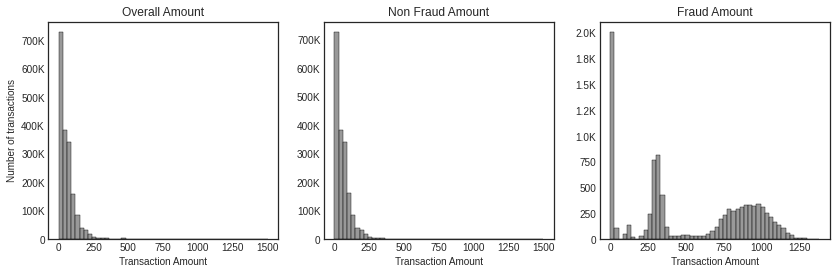

In [120]:
# amount vs fraud

fig, ax = plt.subplots(1, 3,figsize=(14, 4))

#distribution plots
sns.histplot(df_final[df_final.amt <= 1500].amt, bins=50, color='gray', alpha=0.8, ax=ax[0])
sns.histplot(df_final[(df_final.is_fraud==0) & (df_final.amt<=1500)].amt, bins=50, color='gray', alpha=0.8, ax=ax[1])
sns.histplot(df_final[(df_final.is_fraud==1) & (df_final.amt<=1500)].amt, bins=50, color='gray',alpha=0.8, ax=ax[2])


#setting titles
ax[0].set_title('Overall Amount')
ax[1].set_title('Non Fraud Amount')
ax[2].set_title('Fraud Amount')

#setting x labels
ax[0].set_xlabel('Transaction Amount')
ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')

#setting y label
ax[0].set_ylabel('Number of transactions')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

#ax = matplotlib.pyplot.gca()
mkfunc = lambda x, pos: '%1.0fM' % (x * 1e-6) if x >= 1e6 else '%1.0fK' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkfunc_2 = lambda x, pos: '%1.1fM' % (x * 1e-6) if x >= 1e6 else '%1.1fK' % (x * 1e-3) if x >= 1e3 else '%1.0f' % x
mkformatter = ticker.FuncFormatter(mkfunc)
mkformatter_2 = ticker.FuncFormatter(mkfunc_2)

ax[0].yaxis.set_major_formatter(mkformatter)
ax[1].yaxis.set_major_formatter(mkformatter)
ax[2].yaxis.set_major_formatter(mkformatter_2)

plt.subplots_adjust(hspace=12)
plt.show()
fig.savefig('./distamount.png', bbox_inches='tight', dpi=600)

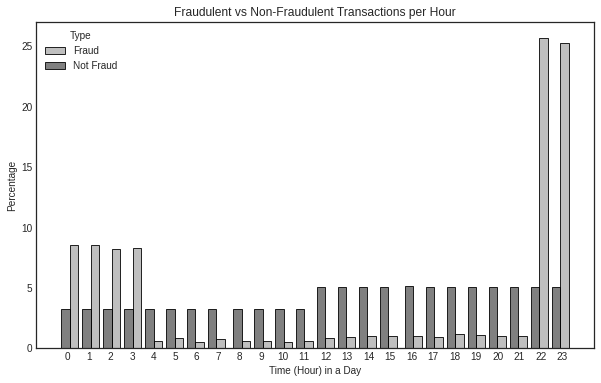

In [150]:
# hour in a day vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="trans_hour", hue="is_fraud", common_norm=False, stat='percent',multiple='dodge',palette='gist_gray', shrink=4)
ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
plt.style.use('seaborn-white')
plt.xticks(np.arange(0,24,1))
plt.title('Fraudulent vs Non-Fraudulent Transactions per Hour')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'], loc='upper left')

plt.show()
fig.savefig('./hour.png', bbox_inches='tight', dpi=600)

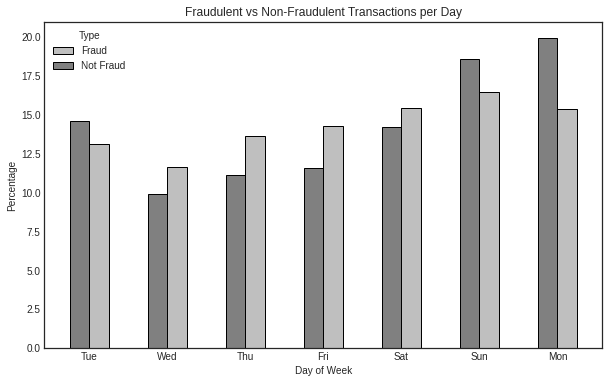

In [151]:
# day of week vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="trans_week_day", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge',palette='gist_gray', shrink=0.5)
ax.set_xticklabels(["Tue","Wed","Thu","Fri","Sat","Sun", "Mon"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.style.use('seaborn-white')
plt.title('Fraudulent vs Non-Fraudulent Transactions per Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'],loc='left')
fig.savefig('./distday.png', bbox_inches='tight', dpi=600)


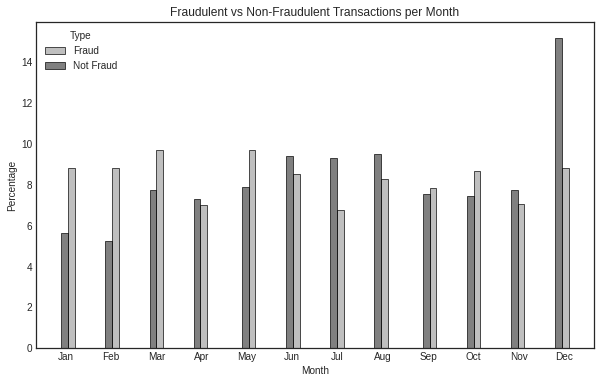

In [152]:
# month vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="trans_month", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge',palette='gist_gray', shrink=3)
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.style.use('seaborn-white')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.title('Fraudulent vs Non-Fraudulent Transactions per Month')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'],loc='left')
fig.savefig('./distmonth.png', bbox_inches='tight', dpi=600)

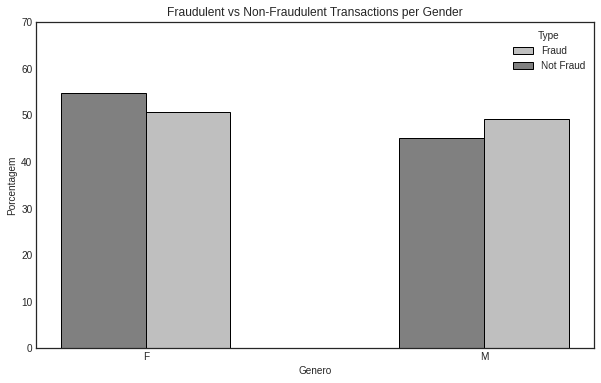

In [153]:
# genero vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="gender", hue="is_fraud", binwidth= 0.5, common_norm=False,stat='percent',multiple='dodge',palette='gist_gray', shrink=0.5)
ax.set_ylabel('Porcentagem')
ax.set_xlabel('Genero')
plt.style.use('seaborn-white')
plt.yticks(np.arange(0,80,10))
plt.title('Fraudulent vs Non-Fraudulent Transactions per Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
fig.savefig('./genero.png', bbox_inches='tight', dpi=600)

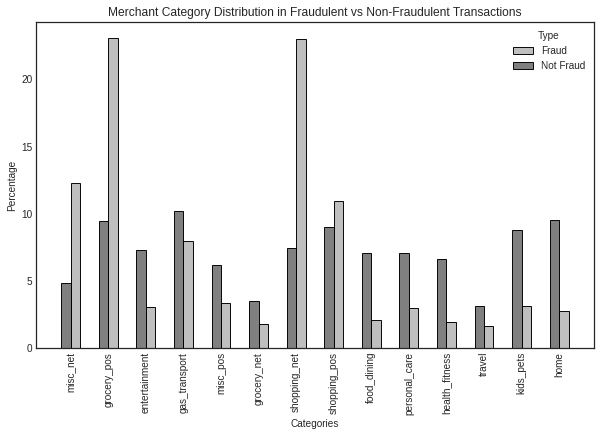

In [149]:
# category vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="category", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge',palette='gist_gray', shrink=0.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Categories')
plt.style.use('seaborn-white')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
plt.title('Merchant Category Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
fig.savefig('./categoryvf.png', bbox_inches='tight', dpi=600)

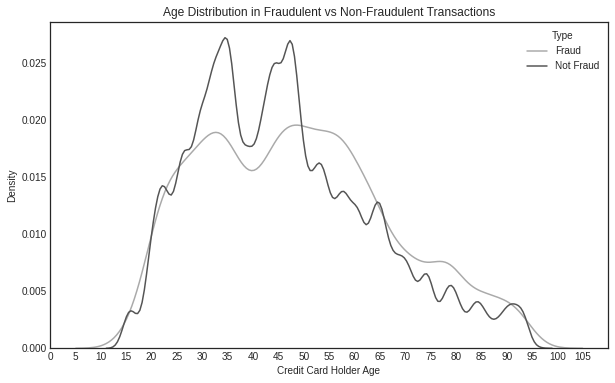

In [144]:
# age vs fraud
fig = plt.figure(figsize=(10,6))
ax=sns.kdeplot(x='age',data=df_final, hue='is_fraud', common_norm=False,palette='gist_gray')
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.style.use('seaborn-white')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
fig.savefig('./age.png', bbox_inches='tight', dpi=600)

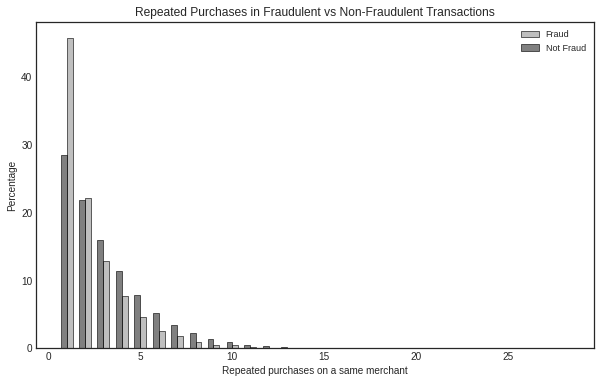

In [146]:
# repeated purchases vs fraude
fig = plt.figure(figsize=(10,6))
ax=sns.histplot(data=df_final, x="qty_purc_unti_now_store", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge',palette='gist_gray', shrink=13)
ax.set_ylabel('Percentage')
ax.set_xlabel('Repeated purchases on a same merchant')
plt.style.use('seaborn-white')
plt.xticks(fontsize=10)
plt.title('Repeated Purchases in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(fontsize=9, labels=['Fraud', 'Not Fraud'])
fig.savefig('./merc_last_hour.png', bbox_inches='tight', dpi=600)